In [1]:
import pandas as pd
import numpy as np

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from ast import literal_eval

import pyLDAvis
import pyLDAvis.gensim

from core.plots import plot_topic_recurrences, plot_words_intopic
from core.hyperparams import compute_coherence_values

/home/otros/maperezc/.local/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Plotting hyperparameter search results

def plot_hprms(values):
    import matplotlib.pyplot as plt
    limit=11; start=2; step=1;
    x = range(start, limit, step)
    plt.plot(x, values, c='k')
    plt.xlabel("Num Topics", fontsize=18)
    plt.axvline(x[np.argmax(values)], linestyle='--', c='r', label='optimal n topics')
    plt.ylabel("Coherence score", fontsize=18)
    plt.title('Topic Modeling LDA', fontsize=18)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Necesidades País

In [3]:
question = 'country' #country or personal

all_needs = pd.read_csv ('data/{}_needs.csv'.format(question))
all_needs['exp_tokens'] = all_needs['exp_tokens'].fillna('NR')
needs = all_needs[all_needs.exp_tokens!='NR'].copy()
tokens = np.array([literal_eval(token) for token in needs.exp_tokens])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Diccionario
id2word = corpora.Dictionary(tokens)

# Corpus
texts = tokens

# Frecuencia de términos de cada documento
corpus = [id2word.doc2bow(text) for text in texts]

In [5]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=tokens, start=2, limit=11, step=1)

max_ix = np.argmax(coherence_values)
plot_hprms(coherence_values)

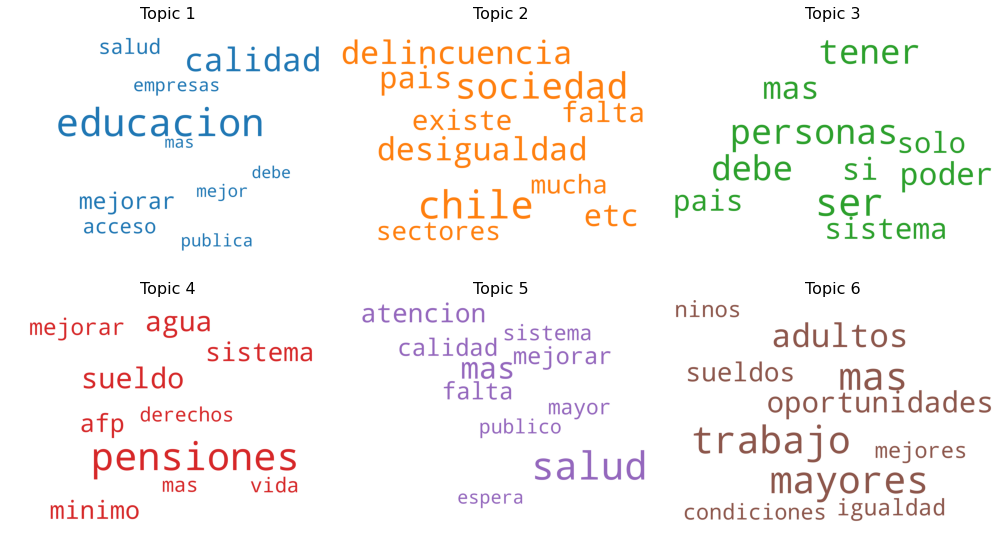

In [6]:
#lda_model = model_list[max_ix] #Best LDA Model
lda_model = gensim.models.LdaMulticore.load('models/{}_lda.model'.format(question)) #If best model was saved.
plot_words_intopic(lda_model)

In [7]:
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=True)
pyLDAvis.display(lda_display)

In [36]:
def predict_topic(lda_model, corpus, topic_dict):
    output = list(lda_model[corpus])[0]
    topics = sorted(output, key=lambda x:x[1], reverse=True)[0]
    return topic_dict[topics[0]]

In [9]:
### Mediante conocimiento experto, los topicos quedaron agrupados:

topic_dict = {
     0:'educacion',
     1:'cambios politicos',
     2:'pensiones',
     3:'pensiones',
     4:'salud',
     5:'condiciones laborales',
     6: 'vivienda y subsistencia',
    'NR': 'NR'
} 


preds = []

ix=0
for need in all_needs.exp_tokens:
    if need!='NR':
        pred = predict_topic(corpus[ix], topic_dict)
        preds.append(pred)
        ix+=1
    else:
        preds.append('NR')
all_needs['macro'] = preds 

all_needs.to_csv('data/{}_needs.csv'.format(question), index=False)
lda_model.save('models/{}_lda.model'.format(question))

## Necesidades Personales

In [20]:
question = 'personal' #country or personal

all_needs = pd.read_csv ('data/{}_needs.csv'.format(question), low_memory=False)
all_needs['exp_tokens'] = all_needs['exp_tokens'].fillna('NR')
needs = all_needs[all_needs.exp_tokens!='NR'].copy()

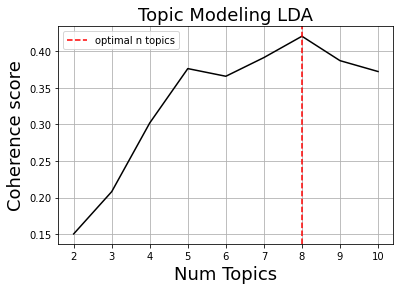

In [15]:
tokens = np.array([literal_eval(token) for token in needs.exp_tokens])
id2word = corpora.Dictionary(tokens)
texts = tokens
corpus = [id2word.doc2bow(text) for text in texts]

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=tokens, start=2, limit=11, step=1)

max_ix = np.argmax(coherence_values)
plot_hprms(coherence_values)

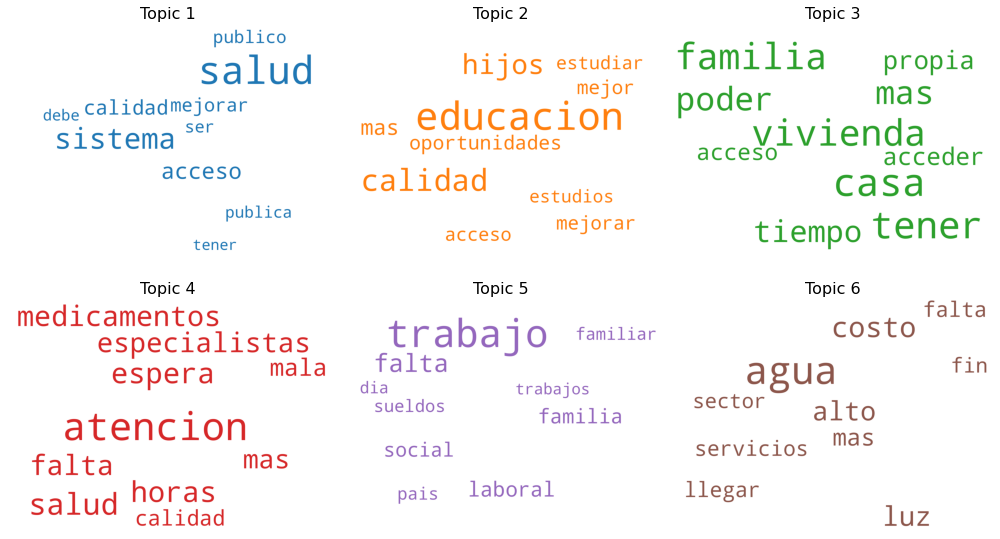

In [38]:
lda_model =  model_list[max_ix] #gensim.models.LdaMulticore.load('models/{}_lda.model'.format(question))
plot_words_intopic(lda_model)

In [41]:
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False) #Topicos ordenados por recurrencia de palabras.
pyLDAvis.display(lda_display)

In [42]:
### Mediante conocimiento experto, los topicos quedaron agrupados:

topic_dict = {
    0:'salud',
    1:'educacion',
    2:'vivienda',
    3:'salud',
    4:'trabajo',
    5:'vivienda',
    6: 'costo de vida',
    7: 'pensiones',
    8: 'oportunidades'
} 

preds = []

ix=0
for need in all_needs.exp_tokens:
    if need!='NR':
        pred = predict_topic(lda_model, corpus[ix], topic_dict)
        preds.append(pred)
        ix+=1
    else:
        preds.append('NR')
all_needs['macro'] = preds 

all_needs.to_csv('data/{}_needs.csv'.format(question), index=False)
lda_model.save('models/{}_lda.model'.format(question))